<a href="https://colab.research.google.com/github/DucNT17/LLMs-Project/blob/main/Exercise_Resnet18_20epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bài thực hành với self-supervised learning
Đây là bài thực hành và ví dụ đối với tác vụ self-supervising learning với pretext task là việc xoay ảnh 4 góc cũng như tác vụ downstream task là việc phân loại ảnh. CSDL được sử dụng là CIAR-10.

Yêu cầu đối với bài thực hành này  gồm:

1. Thực hiện chạy các bước khi áp dụng self-supervised learning để huấn luyện
encoder bằng pretext task --> Sử dụng pretrained encoder để huấn luyện downstream task --> Đánh giá kết quả mô hình huấn luyện
2. Thực hiện một số tác vụ bổ sung. Trước hết, huấn luyện một mô hình phân loại (cùng cấu trúc) không sử dụng self-supervised và so sánh kết quả khi so với mô hình có áp dụng self-supervised trước đó (Bước 6)
3. Hiển thị ngẫu nhiên kết quả phân loại 10 ảnh trong CSDL ảnh CIFAR. Yêu cầu thực hiện lấy ngẫu nhiên theo seed = 42 (khi dùng hàm torch.manual_seed và numpy.manual_seed) (Bước 7 và 8)
4. Tăng số epoch lên 20, 30,... và đánh giá lại kết quả phân loại qua báo cáo
5. Thử thay thế SmallCNN Encoder trong ví dụ mẫu bằng một (vài) mô hình khác (như Resnet18, MobileNetV2, EfficientNet-B0, ....) cho bài toán phân loại đã thực hiện. Viết báo cáo đánh giá kết quả thực hiện bài toán phân loại CSDL CIFAR10 với những mô hình này (có và không sử dụng self-supervised)

Lưu ý: Với yêu cầu số 5, thời gian huấn luyện self-supervised với pretext task có thể sẽ lâu



In [ ]:
from torchvision.models import resnet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import random
import torch.cuda.amp as amp  # For mixed precision training

# Tối ưu hóa cuDNN cho hiệu suất tốt hơn
torch.backends.cudnn.benchmark = True

# Define rotation transformation
class RotationTransform:
    """Rotate an image by one of the given angles."""
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle), self.angles.index(angle)

# Define Resnet18
class ResNet18Encoder(nn.Module):
    def __init__(self):
        super(ResNet18Encoder, self).__init__()
        self.resnet18 = resnet18(pretrained=True) # Sử dụng pre-trained weights, giúp mô hình có sẵn các đặc trưng mạnh mẽ
        self.resnet18.fc = nn.Identity() #loại bỏ lớp phân loại cuối cùng và chỉ giữ lại đầu ra đặc trưng

    def forward(self, x):
        x = self.resnet18(x)
        return x

class RotationPredictionModel(nn.Module):
    def __init__(self, encoder):
        super(RotationPredictionModel, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(512, 4)  # 256 is the output size of SmallCNN, 4 classes for rotation (0°, 90°, 180°, 270°)

    def forward(self, x):
        features = self.encoder(x)
        out = self.fc(features)
        return out


**Bước 2: Chuẩn bị dữ liệu với CIFAR-10**

In [ ]:
# Load CIFAR-10 dataset with rotation transformation
transform = transforms.Compose([
    transforms.Resize(32),  # CIFAR-10 images are 32x32
    transforms.ToTensor()
])

rotation_transform = RotationTransform()

# Load dataset with rotation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Apply rotation transformation
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, rotation_transform):
        self.base_dataset = base_dataset
        self.rotation_transform = rotation_transform

    def __getitem__(self, index):
        img, _ = self.base_dataset[index]
        rotated_img, rotation_label = self.rotation_transform(img)
        return rotated_img, rotation_label

    def __len__(self):
        return len(self.base_dataset)

rotation_train_dataset = RotationDataset(train_dataset, rotation_transform)
rotation_train_loader = DataLoader(rotation_train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)


100%|██████████| 170M/170M [00:06<00:00, 28.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Bước 3: Huấn luyện Pretext Task với Resnet18**

Hãy kiên nhẫn vì thời gian huấn luyện mỗi epoch có thể sẽ khá lâu


In [ ]:
# Initialize the Resnet encoder and pretext task model
encoder = ResNet18Encoder()
rotation_model = RotationPredictionModel(encoder)
rotation_model = rotation_model.cuda()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rotation_model.parameters(), lr=0.001)

# Train the rotation prediction model using mixed precision for faster training
scaler = amp.GradScaler()  # For mixed precision training

def train_rotation_model(model, dataloader, criterion, optimizer, scaler, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            with amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}')

# Train for 10 epochs
train_rotation_model(rotation_model, rotation_train_loader, criterion, optimizer, scaler, epochs=10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]
<ipython-input-5-968cc4e0427d>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  #

Epoch [1/10], Loss: 0.8262286237916168
Epoch [2/10], Loss: 0.6253731033327629
Epoch [3/10], Loss: 0.5532010992874905
Epoch [4/10], Loss: 0.5058146528139407
Epoch [5/10], Loss: 0.469492001801121
Epoch [6/10], Loss: 0.4387537272913115
Epoch [7/10], Loss: 0.4153479095928523
Epoch [8/10], Loss: 0.3928348881249525
Epoch [9/10], Loss: 0.37021866851315205
Epoch [10/10], Loss: 0.35431349429549003


In [ ]:
encoder_path = "resnet_encoder_pretext.pth"
torch.save(encoder.state_dict(), encoder_path)
print(f"Encoder saved to {encoder_path}")

Encoder saved to resnet_encoder_pretext.pth


**Bước 4: Áp dụng Encoder vào Downstream Task (phân loại CIFAR-10)**

In [ ]:
# Define a classifier for CIFAR-10 using the pre-trained encoder
class CIFAR10Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(CIFAR10Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(512, num_classes)  # 256 là số lượng đặc trưng đầu ra của SmallCNN

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)  # Freeze encoder weights during fine-tuning
        out = self.fc(features)
        return out

# Prepare the CIFAR-10 training dataset (without rotation)
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

# Initialize the classifier using the pre-trained SmallCNN encoder
cifar10_classifier = CIFAR10Classifier(encoder=encoder).cuda()

# Define loss and optimizer for downstream task
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar10_classifier.parameters(), lr=0.001)

# Train the classifier on CIFAR-10
def train_cifar10_classifier(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}')

# Train for 10 epochs
train_cifar10_classifier(cifar10_classifier, cifar10_train_loader, criterion, optimizer, epochs=20)


Files already downloaded and verified
Epoch [1/20], Loss: 1.9249487178666251
Epoch [2/20], Loss: 1.6813867450976858
Epoch [3/20], Loss: 1.5859408998975948
Epoch [4/20], Loss: 1.5294250262026885
Epoch [5/20], Loss: 1.494166410090972
Epoch [6/20], Loss: 1.4660105182200063
Epoch [7/20], Loss: 1.442297945825421
Epoch [8/20], Loss: 1.423662891193312
Epoch [9/20], Loss: 1.4086800539980129
Epoch [10/20], Loss: 1.3931876463549477
Epoch [11/20], Loss: 1.3840125750522225
Epoch [12/20], Loss: 1.3710687403776207
Epoch [13/20], Loss: 1.3610655951256654
Epoch [14/20], Loss: 1.3562830114851192
Epoch [15/20], Loss: 1.3494212980173073
Epoch [16/20], Loss: 1.3412247914440778
Epoch [17/20], Loss: 1.33446603101127
Epoch [18/20], Loss: 1.3288465294302727
Epoch [19/20], Loss: 1.3216681796677259
Epoch [20/20], Loss: 1.3194363609868653


In [ ]:
model_path = "resnet18_classification_cifar10.pth"
torch.save(cifar10_classifier.state_dict(), model_path)
print(f"Classification model saved to {encoder_path}")

Classification model saved to resnet_encoder_pretext.pth


**Bước 5: Đánh giá mô hình trên tập dữ liệu kiểm tra**

In [ ]:
# Load the CIFAR-10 test dataset
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=train_transform)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# Evaluate the classifier
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Evaluate on test data
print("Accuracy of classifier with Self-Learning Resnet Encoder:")
evaluate_model(cifar10_classifier, cifar10_test_loader)


Files already downloaded and verified
Accuracy of classifier with Self-Learning Resnet Encoder:
Accuracy: 52.45%


**Bước 7. Hiển thị thử nghiệm 10 ảnh phân loại từ CSDL CIFAR-10 với mô hình huấn luyện có dùng self-supervised learning**

Files already downloaded and verified
Accuracy of classifier with Self-Learning Resnet Encoder:
Accuracy: 52.45%


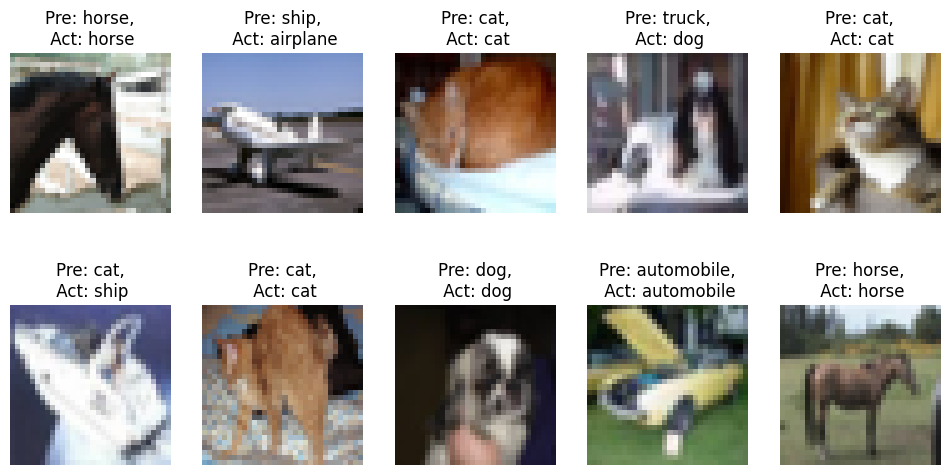

In [ ]:
# ---------------------------WRITE DOWN YOUR CODE HERE--------------------------
import matplotlib.pyplot as plt
# Load the CIFAR-10 test dataset
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=train_transform)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=10, shuffle=False, num_workers=4, pin_memory=True)
images, labels = next(iter(cifar10_test_loader))

# Evaluate the classifier
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    # Hiển thị ảnh và nhãn dự đoán
    classes = cifar10_test_dataset.classes # Lấy danh sách các lớp
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().permute(1, 2, 0).numpy() / 2 + 0.5)  # Hiển thị ảnh
        ax.set_title(f"Pre: {classes[predicted[i]]},\n Act: {classes[labels[i]]}") # Hiển thị nhãn dự đoán và nhãn thực tế
        ax.axis('off')

    plt.show()

# Evaluate on test data
print("Accuracy of classifier with Self-Learning Resnet Encoder:")
evaluate_model(cifar10_classifier, cifar10_test_loader)
#---------------------------YOUR CODE END HERE----------------------------------